In [68]:
import pandas as pd
import geopandas as gpd
from configparser import RawConfigParser
import matplotlib.pyplot as plt
import os, sys

In [2]:
settings_file = 'run_setting.cfg'

In [3]:
config = RawConfigParser(allow_no_value=True)
config.read(settings_file);

In [38]:
def filter_conflicts(config):
    
    conflict_fo = os.path.join(config.get('general', 'input_dir'), 
                               config.get('conflict', 'conflict_file'))
    
    print('reading csv file to dataframe...' + os.linesep)
    df = pd.read_csv(conflict_fo)
    
    selection_criteria = {'best': config.getint('conflict', 'min_nr_casualties'),
                          'type_of_violence': config.getint('conflict', 'type_of_conflict'),
                          'country': config.get('conflict', 'country')}
    
    print('filtering conflict database...' + os.linesep)
    
    for key in selection_criteria:

        if selection_criteria[key] == '':
            print('...passing key', key, 'as it is empty')
            pass

        elif isinstance(selection_criteria[key], (int)):
            if key == 'type_of_violence':
                print('...filtering key', key, 'with value', selection_criteria[key])
                df = df.loc[(df[key] == selection_criteria[key])]
            else:
                print('...filtering key', key, 'with lower value', selection_criteria[key])
                df = df.loc[(df[key] >= selection_criteria[key])]

        elif (isinstance(selection_criteria[key], (str))):
            print('...filtering key', key, 'with value', selection_criteria[key])
            df = df.loc[(df[key] == selection_criteria[key])]
    
    return df

In [44]:
def pd_to_gpd_dataframe(df, longitude='longitude', latitude='latitude', crs='EPSG:4326'):
    
    df = gpd.GeoDataFrame(df,
                          geometry=gpd.points_from_xy(df[longitude], df[latitude]),
                          crs=crs)
    
    return df

In [66]:
def clip_to_continent(gdf, continent='Africa', plot_bnds=False):
    
    world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
    continent_gdf = world[world["continent"] == continent]
    
    df = gpd.clip(gdf, continent_gdf)
    
    if plot_bnds:
        ax = df.plot(figsize=(10,5), legend=True, label='PRIO/UCDP events')
        continent_gdf.boundary.plot(ax=ax, color='0.5', linestyle=':')
        plt.legend()
        ax.set_xlim(continent_gdf.total_bounds[0]-1, continent_gdf.total_bounds[2]+1)
        ax.set_ylim(continent_gdf.total_bounds[1]-1, continent_gdf.total_bounds[3]+1)
    
    return gdf, continent_gdf

In [49]:
sel_conflict_df = filter_conflicts(config)

reading csv file to dataframe...

filtering conflict database...

...filtering key best with lower value 5
...filtering key type_of_violence with value 1
...passing key country as it is empty


In [60]:
sel_conflict_gdf = pd_to_gpd_dataframe(sel_conflict_df)

,id,year,active_year,type_of_violence,conflict_new_id,conflict_name,dyad_new_id,dyad_name,side_a_new_id,gwnoa,...,date_start,date_end,deaths_a,deaths_b,deaths_civilians,deaths_unknown,low,best,high,geometry
0,67972,2013,1,1,11347,Mali: Government,12571,Government of Mali - MUJAO,72,432.0,...,2013-01-11,2013-01-12,12,16,3,0,31,31,50,POINT (-3.89474 14.94329)
1,23385,2004,1,3,583,FNI - Civilians,1050,FNI - Civilians,606,NaN,...,2004-01-14,2004-01-16,0,0,200,0,100,200,200,POINT (30.77583 1.76972)
2,24255,2007,0,2,4600,CNDP - PARECO,5210,CNDP - PARECO,426,NaN,...,2007-12-13,2007-12-18,0,0,4,0,4,4,4,POINT (28.87694 -1.65194)
3,82612,2008,1,1,364,India: Kashmir,792,Government of India - Kashmir insurgents,141,750.0,...,2008-03-04,2008-03-05,0,2,0,0,2,2,2,POINT (74.72549 34.37893)
4,82645,2008,1,1,364,India: Kashmir,792,Government of India - Kashmir insurgents,141,750.0,...,2008-06-30,2008-07-01,1,11,0,0,12,12,12,POINT (74.16729 34.37260)


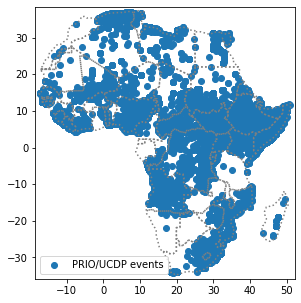

In [69]:
africa_conflict_gdf, africa_gdf = clip_to_continent(sel_conflict_gdf, plot_bnds=True)